In [10]:
# Benchmarking with sktime
# The benchmarking modules allows us to easily orchestrate benchmarking experiments in which 
# we want to compare the performance of one or more algorithms over one or more data sets. 
# It also provides a number of statistical tests to check if observed performance differences are statistically significant.

# The benchmarking modules is based on mlaut.



# import required functions and classes
import os

from sklearn.metrics import accuracy_score

from sktime.benchmarking.data import UEADataset, make_datasets
from sktime.benchmarking.evaluation import Evaluator
from sktime.benchmarking.metrics import PairwiseMetric
from sktime.benchmarking.orchestration import Orchestrator
from sktime.benchmarking.results import HDDResults
from sktime.benchmarking.strategies import TSCStrategy
from sktime.benchmarking.tasks import TSCTask
from sktime.classification.frequency_based import RandomIntervalSpectralForest
from sktime.classification.interval_based import TimeSeriesForest
from sktime.series_as_features.model_selection import PresplitFilesCV

In [11]:
# set up paths to data and results folder
import sktime

DATA_PATH = os.path.join(os.path.dirname(sktime.__file__), "datasets/data")
RESULTS_PATH = "results"

In [12]:
# Create individual pointers to dataset on the disk
datasets = [
    UEADataset(path=DATA_PATH, name="ArrowHead"),
    UEADataset(path=DATA_PATH, name="ItalyPowerDemand"),
]

In [13]:
# Alternatively, we can use a helper function to create them automatically
datasets = make_datasets(
    path=DATA_PATH, dataset_cls=UEADataset, names=["ArrowHead", "ItalyPowerDemand"]
)

In [14]:
# For each dataset, we also need to specify a learning task
# The learning task encapsulate all the information and instructions that define the problem we're trying to solve. 
# In our case, we're trying to solve classification tasks and the key information 
# we need is the name of the target variable in the data set that we're trying to predict. 
# Here all tasks are the same because the target variable has the same name in all data sets.


tasks = [TSCTask(target="target") for _ in range(len(datasets))]

In [15]:
# Specify learning strategies
# Having set up the data sets and corresponding learning tasks, we need to define the algorithms 
# we want to evaluate and compare.


# Specify learning strategies
strategies = [
    TSCStrategy(TimeSeriesForest(n_estimators=10), name="tsf"),
    TSCStrategy(RandomIntervalSpectralForest(n_estimators=10), name="rise"),
]

In [16]:
# Set up a results object
# The results object encapsulates where and how benchmarking results are stored, 
# here we choose to output them to the hard drive.



# Specify results object which manages the output of the benchmarking
results = HDDResults(path=RESULTS_PATH)

c:\users\rbabayev\pythonprojects\py_scripts\sktime\sktime\benchmarking\base.py:153: UserWarning: Existing results file found in given path: results. Results file will be updated
  warn(f"Existing results file found in given path: {path}. "


In [17]:
import shutil
shutil.rmtree(RESULTS_PATH)

results = HDDResults(path=RESULTS_PATH)

In [18]:
# Run benchmarking

# Finally, we pass all specifications to the orchestrator. 
# The orchestrator will automatically train and evaluate all algorithms on all data sets and write out the results.


# run orchestrator
orchestrator = Orchestrator(
    datasets=datasets,
    tasks=tasks,
    strategies=strategies,
    cv=PresplitFilesCV(),
    results=results,
)
orchestrator.fit_predict(save_fitted_strategies=False, overwrite_predictions=True)

In [19]:
# Evaluate and compare results
# Having run the orchestrator, we can evaluate and compare the prediction strategies.


evaluator = Evaluator(results)
metric = PairwiseMetric(func=accuracy_score, name="accuracy")
metrics_by_strategy = evaluator.evaluate(metric=metric)
metrics_by_strategy.head()

,strategy,accuracy_mean,accuracy_stderr
0,rise,0.814363,0.020893
1,tsf,0.857279,0.019271


In [20]:
# The evaluator offers a number of additional methods for evaluating and comparing strategies, 
# including statistical hypothesis tests and visualisation tools, for example:

evaluator.rank()

,strategy,accuracy_mean_rank
0,rise,2.0
1,tsf,1.0


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'accuracy by strategy'}, xlabel='strategies', ylabel='accuracy'>)

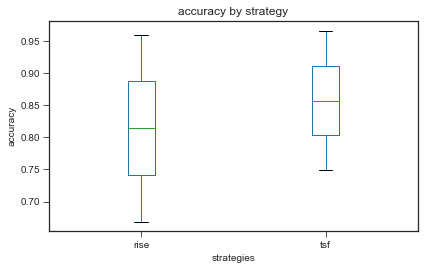

In [21]:
# Currently, the following functions are implemented:

# evaluator.plot_boxplots()
# evaluator.ranks()
# evaluator.t_test()
# evaluator.sign_test()
# evaluator.ranksum_test()
# evaluator.t_test_with_bonferroni_correction()
# evaluator.wilcoxon_test()
# evaluator.friedman_test()
# evaluator.nemenyi()


evaluator.plot_boxplots()

In [22]:
evaluator.ranksum_test()

(  estimator_1 estimator_2     p_val    t_stat
 0        rise        rise  1.000000  0.000000
 1        rise         tsf  0.438578 -0.774597
 2         tsf        rise  0.438578  0.774597
 3         tsf         tsf  1.000000  0.000000,
           rise                 tsf          
         t_stat     p_val    t_stat     p_val
 rise  0.000000  1.000000 -0.774597  0.438578
 tsf   0.774597  0.438578  0.000000  1.000000)